In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import torch

from jerschow_reconstruction_fourier_nn import InverseContinuousCurrentPropagator2d
from magrec.nn.models import Fourier2dMagneticField
from magrec.misc.sampler import GridSampler
from magrec.nn.utils import isoptimizable
from magrec.prop.Fourier import FourierTransform2d
from magrec.misc.plot import plot_n_components

import matplotlib.pyplot as plt

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [3]:
u_NN = Fourier2dMagneticField()

In [4]:
kpoints = GridSampler.sample_grid(51, 26, [-5, 0], [5, 5])

In [5]:
isoptimizable(u_NN, kpoints)

Encountered error:
"mse_cpu" not implemented for 'ComplexFloat'


False

In [6]:
def gaussian_test_fn(kpoints):
    kx, ky = kpoints[:, 0], kpoints[:, 1]
    return torch.exp(-torch.pi * (kx**2 + ky**2))

In [7]:
def Fourier2dMagneticFieldToRealSpace(b_fn):
    ft = FourierTransform2d(grid_shape=(10, 20), dx=1, dy=1, real_signal=True)
    
    def field2d(kpoints):
        bpts = b_fn(kpoints)
        bgrid = GridSampler.pts_to_grid(bpts, nx_points=51, ny_points=26)
        bgrid = torch.fft.ifftshift(bgrid, dim=(-2,))
        Bgrid = torch.fft.fftshift(ft.backward(bgrid, dim=(-2, -1)))
        return Bgrid
    
    return field2d

In [8]:
field = Fourier2dMagneticFieldToRealSpace(gaussian_test_fn)

In [9]:
field(kpoints).shape

torch.Size([1, 51, 50])

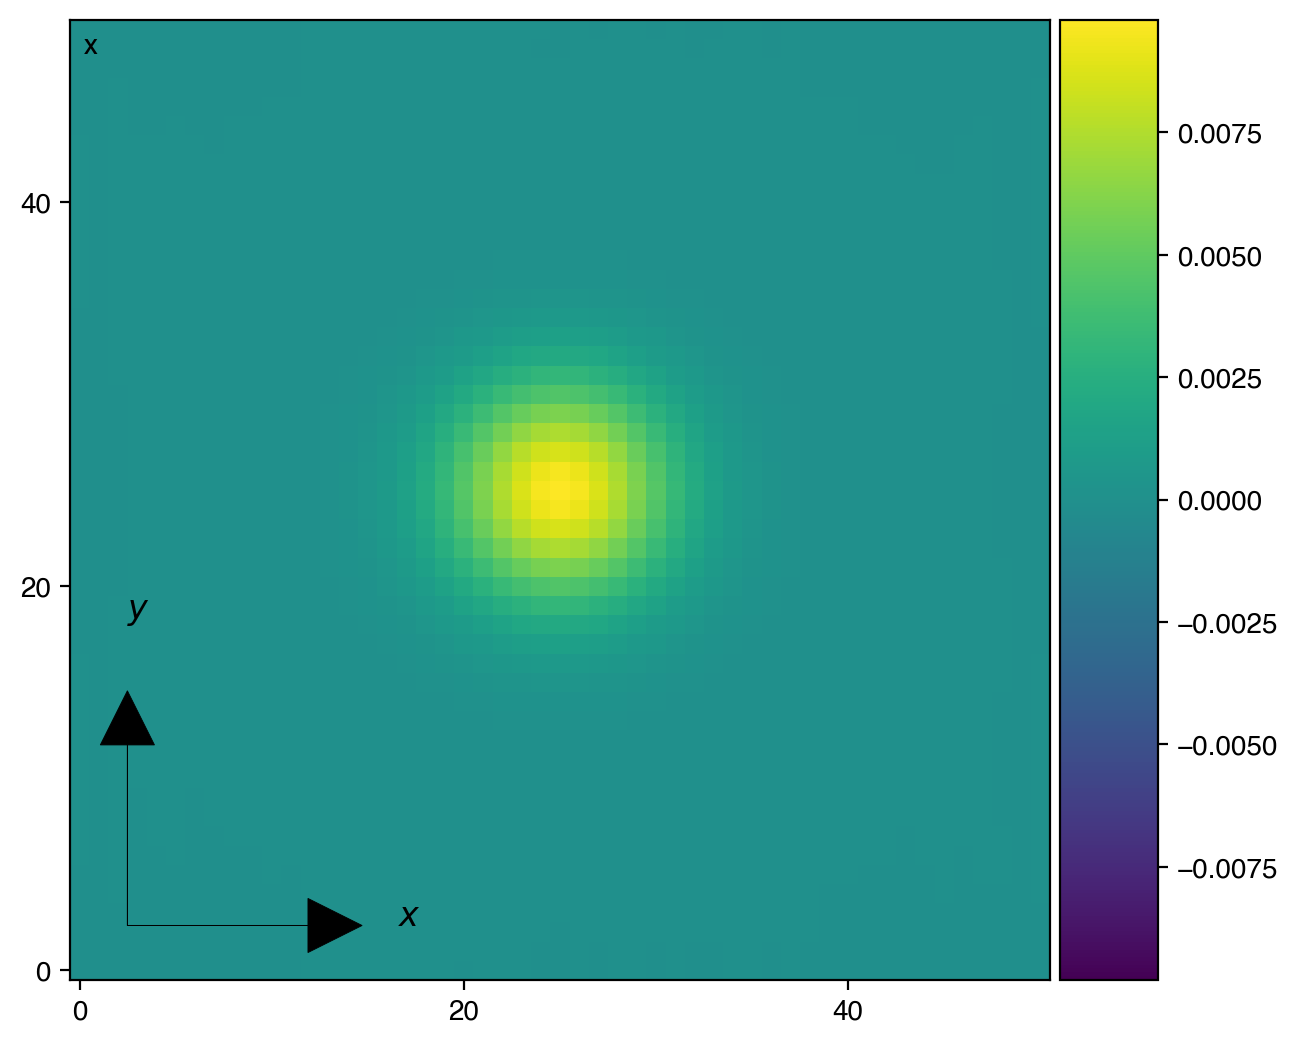

In [10]:
plot_n_components(field(kpoints))

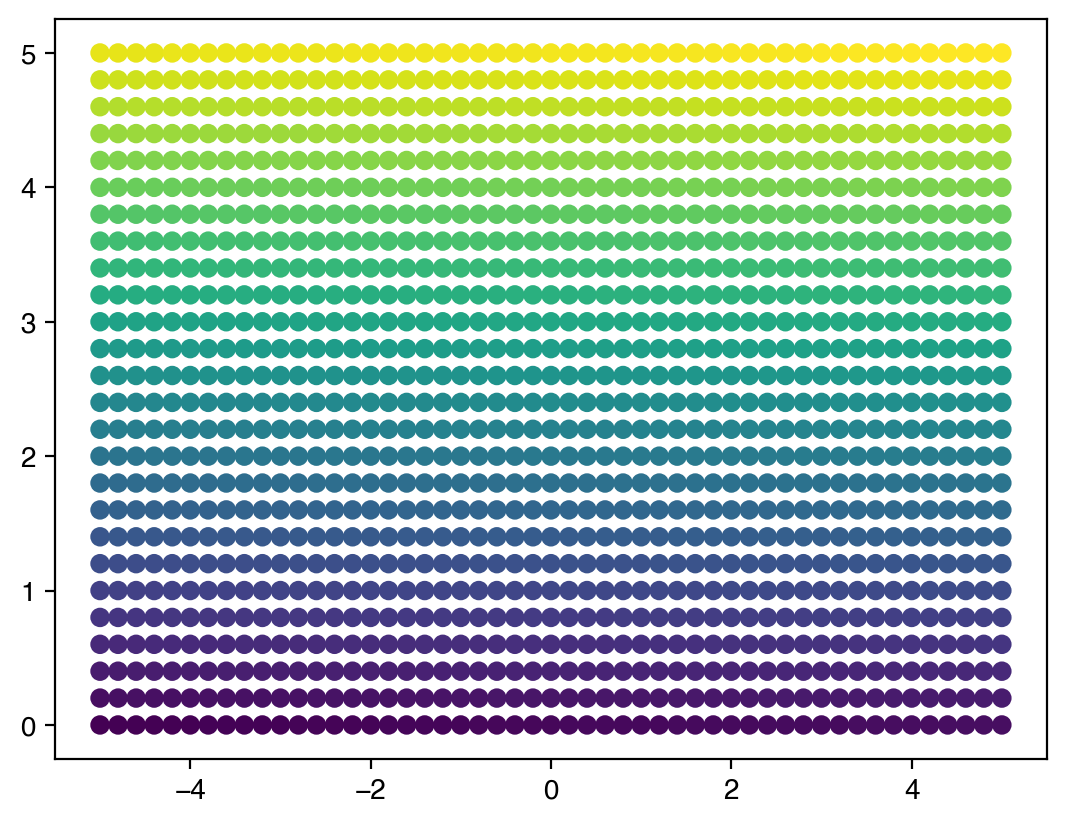

In [11]:
plt.scatter(x=kpoints[:, 0], y=kpoints[:, 1], c=torch.arange(kpoints.shape[0]))

In [13]:
import plotly.graph_objects as go

go.backend = 'plotly_mimetype+notebook_connected'

X, Y = torch.meshgrid(torch.linspace(-5, 5, 50), torch.linspace(0, 5, 50), indexing='xy')
Z = field(kpoints).squeeze().numpy()

fig = go.Figure(data=[go.Surface(x=X.numpy(), y=Y.numpy(), z=Z)])

fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'))

fig.show()

